# Imports

In [1]:
!pip install biopython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
from Bio import SeqIO
import tensorflow as tf
tf.enable_eager_execution()
from tensorflow import keras
print('tf version:',tf.__version__)
print('keras version:',keras.__version__)


tf version: 1.15.3
keras version: 2.2.4-tf


# Settings

In [3]:
test_fasta = '../data/test_13_classes.fasta'
train_fasta = '../data/train.fasta' 
val_fasta = '../data/val.fasta'

# inspect data

In [4]:
with open(test_fasta) as fasta_file:  # Will close handle cleanly
    identifiers = []
    lengths = []
    seqs = []
    classes = []

    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        seqs.append(seq_record.seq)
        classes.append(seq_record.description.split()[1])
        lengths.append(len(seq_record.seq))

    df = pd.DataFrame({
        'identifier':identifiers,
        'family':classes,
        'seq':seqs,
        'length':lengths         
        })

In [5]:
df.head

<bound method NDFrame.head of                              identifier   family  \
0         RF00001_AGFK01083378_1_200-82  5S_rRNA   
1        RF00001_ABIM01030413_1_269-151  5S_rRNA   
2             RF00001_FJ968867_1_23-141  5S_rRNA   
3      RF00001_AFEY01299926_1_3191-3073  5S_rRNA   
4      RF00001_ACYM01068335_1_1131-1013  5S_rRNA   
...                                 ...      ...   
2595  RF02535_ABQO010479098_1_2462-2621     IRES   
2596  RF02535_ABQO010931335_1_1612-1466     IRES   
2597     RF02535_ABVD01851849_1_606-739     IRES   
2598   RF02535_AAGU03005870_1_8100-7981     IRES   
2599   RF02535_ABRP01282070_1_4603-4725     IRES   

                                                    seq  length  
0     (G, G, A, T, G, C, G, A, T, C, A, T, G, T, C, ...     119  
1     (G, G, G, T, G, C, G, A, T, C, A, T, A, C, C, ...     119  
2     (G, C, T, T, A, C, G, G, C, C, A, C, A, C, C, ...     119  
3     (A, G, C, T, A, C, G, G, C, C, A, T, A, T, C, ...     119  
4     (G, G, T,

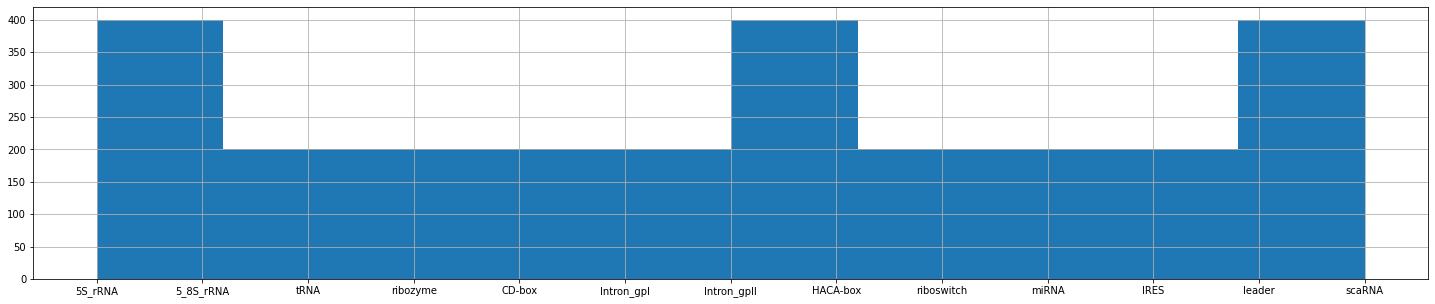

In [6]:
df.family.hist(figsize=(25,5))

# Load and Preprocess

In [7]:
w_to_idx = {"<PAD>": 0, "A": 1, "G": 2, "C": 3, "T": 4, "N": 5, "M": 6, "R": 7, "Y": 8, "W": 9,
              "K": 10, "S": 11, "H": 12, "V": 13, "B": 14, "D": 15}
families = [
           '5S_rRNA',
           '5_8S_rRNA',
           'CD-box',
           'HACA-box',
           'IRES',
           'Intron_gpI',
           'Intron_gpII',
           'leader',
           'miRNA',
           'riboswitch',
           'ribozyme',
           'scaRNA',
           'tRNA'
           ]
fam_to_idx = {}
for i,f in enumerate(families):
    fam_to_idx[f] = i

In [8]:
def read_file(fname, mapper=w_to_idx):

    with open(fname) as fasta_file:  # Will close handle cleanly
        identifiers = []
        lengths = []
        seqs = []
        classes = []

        for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
            identifiers.append(seq_record.id)
            seqs.append(seq_record.seq)
            classes.append(seq_record.description.split()[1])
            lengths.append(len(seq_record.seq))

    df = pd.DataFrame({
        'identifier':identifiers,
        'family':classes,
        'seq':seqs,
        'length':lengths         
        })

    x_idxss = [[w_to_idx[w] for w in seq][0:min(len(seq),750)]+[w_to_idx['<PAD>']]*(750 - len(seq)) for seq in seqs]
    y_idxs = [fam_to_idx[f] for f in classes]

    xs = tf.convert_to_tensor([tf.one_hot(idxs, len(w_to_idx)) for idxs in x_idxss])
    ys = tf.one_hot(y_idxs, len(families))
    
    return xs,ys,df
        
        

In [9]:
xs_test, ys_test,df = read_file(test_fasta)
xs_train, ys_train,_ = read_file(train_fasta)
xs_val ,ys_val,df = read_file(val_fasta)

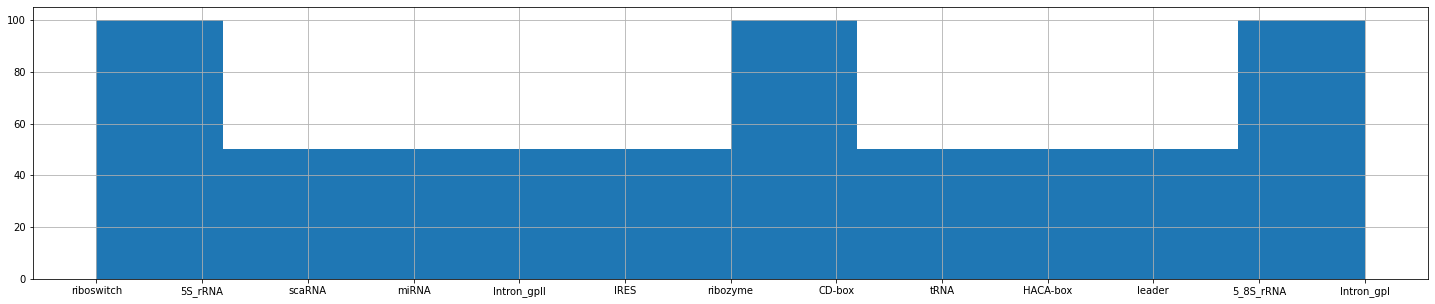

In [10]:
df.family.hist(figsize=(25,5))

# Model

In [11]:
from tensorflow.keras.layers import MaxPooling1D, Dropout, Dense, Flatten, Conv1D, BatchNormalization, Activation
from tensorflow.keras import Model, activations

In [12]:
print('dimension of x',xs_train.shape)
print('dimension of y',ys_train.shape)

dimension of x (5670, 750, 16)
dimension of y (5670, 13)


In [28]:
class MyModel(Model):
    def __init__(self, nc=1, nd=1, nfilter=32, filter_size=10, dense_node=256):
        super(MyModel, self).__init__()
        self.nc = nc
        self.nd = nd
        # conv block
        self.c_conv = [Conv1D(nfilter, filter_size, activation='relu') for i in range(nc)]
        self.c_batchnorm = [BatchNormalization() for i in range(nc)]
        self.c_dropout =  [Dropout(0.2) for i in range(nc)]
        self.c_activation = [Activation(activations.relu) for i in range(nc)]
        self.c_maxpool = [MaxPooling1D(2,2) for i in range(nc)]
        
        self.flat = Flatten()
        
        # dense block
        self.d_dense = [Dense(dense_node, activation='relu') for i in range(nd)]
        self.d_batchnorm = [BatchNormalization() for i in range(nd)]
        self.d_dropout = [Dropout(0.2) for i in range(nd)]
        self.d_activation = [Activation(activations.relu) for i in range(nd)]

        # final result
        self.d1 = Dense(13)

    def call(self, x):
        for i in range(self.nc):
            x = self.c_conv[i](x)
            x = self.c_batchnorm[i](x)
            x = self.c_dropout[i](x)
            x = self.c_activation[i](x)
            x = self.c_maxpool[i](x)
            
        x = self.flat(x)
        
        for i in range(self.nd):
            x = self.d_dense[i](x)
            x = self.d_batchnorm[i](x)
            x = self.d_dropout[i](x)
            x = self.d_activation[i](x)

        return self.d1(x)

# model = MyModel(3,3)

In [29]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(filters=8, kernel_size=(2,2)),
#     tf.keras.layers.Flatten(input_shape=(750, 16)),

#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(13)
# ])


## Categorical cross-entropy loss

In [30]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [31]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# model.compile(optimizer='adam',
#               loss=loss_fn,
#               metrics=['accuracy'])
# history = model.fit(xs_train, ys_train, batch_size=128, epochs=15, callbacks=[callback])
# model.evaluate(xs_test,  ys_test, verbose=2)

In [32]:
# model.evaluate(xs_test,  ys_test, verbose=2)

# Tune

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
# len(epochs)*len(nds)*len(ncs)*len(nfilters)*len(filtersizes)*len(densenodes)

In [35]:
epochs = range(5,6)
nds = range(1,2)
ncs = range(1,2)
nfilters = [8,9]
filtersizes = [2,4]
densenodes =[16,32]

In [36]:
epochs = range(5,26)
nds = range(1,4)
ncs = range(1,4)
nfilters = [8,16,32,64,128,256,512]
filtersizes = [2,3,4,5,6,7,8,10,12,14,16,20]
densenodes =[16,32,64,128,256]

In [37]:
def train(nepoch=6,nc=1,nd=1,nfilter=16,filter_size=4,dense_node=32):
    param = {'nepoch':nepoch,'nc':nc,'nd':nd,'nfilter':nfilter,'filter_size':filter_size,'dense_node':dense_node}
    print('param',param)
    model = MyModel(nc,nd,nfilter,filter_size,dense_node)
    model.compile(optimizer='adam',
                  loss=loss_fn,
                  metrics=['accuracy'])
    history = model.fit(xs_train, ys_train, batch_size=128, epochs=nepoch, 
                        validation_data=(xs_val, ys_val), callbacks=[callback])
#     res = model.evaluate(xs_val,  ys_val, verbose=2)
    return history, res, param

In [38]:

# histories = []
# evals = []
# params = []


# max_accu = 0
# max_epoch = 0
# for i in epochs:
#     history, res, param = train(nepoch = i)
#     histories.append(history)
#     evals.append(res)
#     params.append(param)
#     if res[1] > max_accu:
#         max_accu = res[1]
#         max_epoch = i

# max_accu = 0
# max_nd = 0
# for i in nds:
#     history, res, param = train(nepoch = max_epoch, nd=i)
#     histories.append(history)
#     evals.append(res)
#     params.append(param)
#     if res[1] > max_accu:
#         max_accu = res[1]
#         max_nd = i

# max_accu = 0
# max_nc = 0
# for i in ncs:
#     history, res, param = train(nepoch = max_epoch, nd=max_nd, nc=i)
#     histories.append(history)
#     evals.append(res)
#     params.append(param)
#     if res[1] > max_accu:
#         max_accu = res[1]
#         max_nc = i
        
# max_accu = 0
# max_nfilter = 0
# for i in nfilters:
#     history, res, param = train(nepoch = max_epoch, nd=max_nd, nc=max_nc, nfilter=i)
#     histories.append(history)
#     evals.append(res)
#     params.append(param)
#     if res[1] > max_accu:
#         max_accu = res[1]
#         max_nfilter = i

# max_accu = 0
# max_filtersizes = 0
# for i in filtersizes:
#     history, res, param = train(nepoch = max_epoch, nd=max_nd, nc=max_nc, nfilter=max_nfilter, filter_size=i)
#     histories.append(history)
#     evals.append(res)
#     params.append(param)
#     if res[1] > max_accu:
#         max_accu = res[1]
#         max_filtersizes = i
        
# max_accu = 0
# max_densenodes = 0
# for i in densenodes:
#     history, res, param = train(nepoch = max_epoch, nd=max_nd, nc=max_nc, nfilter=max_nfilter, filter_size=max_filtersizes, dense_node=i)
#     histories.append(history)
#     evals.append(res)
#     params.append(param)
#     if res[1] > max_accu:
#         max_accu = res[1]
#         max_densenodes = i
        


In [39]:
# history, res, param = train(nepoch = 25, nd=2, nc=2, nfilter=8, filter_size=10)

In [43]:
xs_val

<tf.Tensor: id=44612, shape=(650, 750, 16), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
     

In [44]:
histories

NameError: name 'histories' is not defined

In [45]:
evals

NameError: name 'evals' is not defined

In [46]:
params

NameError: name 'params' is not defined

In [47]:
# history, res, param = train(nepoch = 25, nd=2, nc=2, nfilter=8, filter_size=16)

In [48]:
history, res, param = train(nepoch = 25, nd=2, nc=2, nfilter=128, filter_size=20)

param {'nepoch': 25, 'nc': 2, 'nd': 2, 'nfilter': 128, 'filter_size': 20, 'dense_node': 32}
Train on 5670 samples, validate on 650 samples
Epoch 1/25
5670/5670 [==============================] - 91s 16ms/sample - loss: 2.2785 - acc: 0.2534 - val_loss: 2.5653 - val_acc: 0.0800
Epoch 2/25
3328/5670 [================>.............] - ETA: 34s - loss: 1.8089 - acc: 0.4228

KeyboardInterrupt: 